In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

from torchmetrics.classification import BinaryAccuracy

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
device = "cpu"

In [ ]:
magic_df = pd.read_csv("data/magic04.csv", header=None)

magic_df

In [ ]:
# magic_df[10] = magic_df[10].apply(lambda x: 0 if x == -1 else 1)
magic_df[10].value_counts()

In [ ]:
magic_df[10].value_counts(normalize=True)

In [ ]:
magic_df.groupby(10).agg({10:'count'}).plot.bar()

In [ ]:
corr = magic_d.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, cmap='RdBu')

In [7]:
y = pd.get_dummies(magic_df.iloc[:, -1], prefix="10")
# y = torch.Tensor(y.values)
y

,10_-1,10_1
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
18617,0,1
18618,0,1
18619,0,1
18620,0,1


In [8]:
x = magic_df.iloc[:, :-1]
# x = torch.Tensor(x.values)
x

,0,1,2,3,4,5,6,7,8,9
0,0.296208,0.085816,0.406505,0.106035,0.106831,0.390870,0.657489,0.494704,0.982929,0.553649
1,0.264850,0.073442,0.227203,0.483578,0.506297,0.392227,0.410353,0.489440,0.709816,0.262033
2,0.639720,0.264542,0.443022,0.140016,0.106979,0.732251,0.415194,0.385419,0.854711,0.489160
3,0.472227,0.339511,0.609610,0.091942,0.074826,0.412321,0.285033,0.391743,0.113370,0.589703
4,0.047007,0.075485,0.208368,0.591090,0.396355,0.457517,0.590456,0.509181,0.889363,0.126393
...,...,...,...,...,...,...,...,...,...,...
18617,0.210467,0.089468,0.414991,0.219911,0.156023,0.522742,0.688964,0.495537,0.096722,0.438029
18618,0.063433,0.054588,0.117741,0.526083,0.355608,0.430602,0.567477,0.502047,0.558220,0.385304
18619,0.054826,0.025611,0.054465,0.827935,0.560083,0.418438,0.570193,0.551346,0.353000,0.555916
18620,0.093179,0.075923,0.394559,0.359814,0.244184,0.465129,0.628841,0.514169,0.008557,0.379607


In [9]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

y_train['10_1'].value_counts()

1    9613
0    5284
Name: 10_1, dtype: int64

In [10]:
train_set_positive = X_train[y_train['10_1'] == 1]
train_set_negative = X_train[y_train['10_1'] == 0]

train_set_positive.shape, train_set_negative.shape

((9613, 10), (5284, 10))

In [11]:
# Source: https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/
class VariationalAutoencoder(nn.Module):
    def __init__(self, num_features=8, num_dim=30):
        super(VariationalAutoencoder, self).__init__()
        
        self.num_features = num_features
        self.num_dim = num_dim
        
        self.encoder_layer_1 = nn.Linear(in_features=self.num_dim, out_features=512)
        self.encoder_layer_2 = nn.Linear(in_features=512, out_features=(self.num_features * 2))
        
        self.decoder_layer_1 = nn.Linear(in_features=self.num_features, out_features=512)
        self.decoder_layer_2 = nn.Linear(in_features=512, out_features=self.num_dim)
        
        self.relu = nn.ReLU() # hidden layers
        self.sigmoid = nn.Sigmoid() # output layer
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std)  # `randn_like` as we need the same size
        sample = mu + (eps * std)    # sampling as if coming from the input space
        
        return sample
    
    def encode(self, x):
        # encoding
        #x = F.relu(self.encoder_layer_1(x))
        x = self.encoder_layer_1(x)
        x = self.relu(x)
        x = self.encoder_layer_2(x).view(-1, 2, self.num_features)
        
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        
        return z, mu, log_var
    
    def decode(self, z, mu, log_var):
        # decoding
        #x = F.relu(self.decoder_layer_1(z))
        x = self.decoder_layer_1(z)
        x = self.relu(x)
        
        #reconstruction = torch.sigmoid(self.decoder_layer_2(x))
        reconstruction = self.decoder_layer_2(x)
        reconstruction = self.sigmoid(reconstruction)
        
        return reconstruction, mu, log_var
    
    # Utility function to generate new data based on:
    # mu: The average that you want to have (should be the same size as num_features)
    # log_var: The variance that you want to have (should be the same size as num_features)
    def sample(self, mu, log_var):
        z = self.reparameterize(mu, log_var)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)
        
        return reconstruction
        
    
    def forward(self, x):
        
        z, mu, log_var = self.encode(x)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)
        
        return reconstruction, mu, log_var

In [12]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class AutoencoderDataset(Dataset):
    def __init__(self, x):
        self.x = x
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.x[index]

In [13]:
# The final loss is a combination of the reconstruction loss (first argument) and the loss from an assumed distribution (i.e. Normal / Gaussian distribution)
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [14]:
num_features = 36
num_dim = 10
model = VariationalAutoencoder(num_features=num_features, num_dim=num_dim)

In [15]:
learning_rate = 0.0001
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 32

In [16]:
# Define the training process
# Each call of the train function == 1 Epoch
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        reconstruction, mu, logvar = model.forward(data)
        
        loss = loss_fn(reconstruction, targets)
        
        loss = final_loss(loss, mu, logvar)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

In [17]:
# data = []

# for img in images:
#     data.append(img.ravel())

# x = torch.Tensor(np.array(data))

x = torch.Tensor(train_set_negative.values).to(device)

# use Dataloader for Autoencoder 
custom_dataset = AutoencoderDataset(x)

train_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

In [18]:
epochs = 100
losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))
    
    state = { 'state_dict': model.state_dict() }

    torch.save(state, "models/variational-autoencoder.pth")

Epoch: 0


100%|█████████████| 166/166 [00:00<00:00, 179.66it/s, loss=0.622]


Ave Loss: 2.603245795132166
Epoch: 1


100%|█████████████| 166/166 [00:00<00:00, 179.36it/s, loss=0.606]


Ave Loss: 0.7419844366699816
Epoch: 2


100%|█████████████| 166/166 [00:00<00:00, 195.52it/s, loss=0.601]


Ave Loss: 0.6757812539497053
Epoch: 3


100%|█████████████| 166/166 [00:00<00:00, 191.80it/s, loss=0.604]


Ave Loss: 0.6528638260192182
Epoch: 4


100%|█████████████| 166/166 [00:00<00:00, 185.52it/s, loss=0.603]


Ave Loss: 0.6425697214632149
Epoch: 5


100%|█████████████| 166/166 [00:00<00:00, 185.15it/s, loss=0.602]


Ave Loss: 0.6368925377547022
Epoch: 6


100%|█████████████| 166/166 [00:00<00:00, 181.26it/s, loss=0.599]


Ave Loss: 0.6335192053432924
Epoch: 7


100%|█████████████| 166/166 [00:00<00:00, 188.64it/s, loss=0.601]


Ave Loss: 0.6310786723372448
Epoch: 8


100%|█████████████| 166/166 [00:00<00:00, 196.25it/s, loss=0.598]


Ave Loss: 0.6294410440577082
Epoch: 9


100%|█████████████| 166/166 [00:00<00:00, 197.17it/s, loss=0.604]


Ave Loss: 0.6281524174902813
Epoch: 10


100%|█████████████| 166/166 [00:01<00:00, 151.45it/s, loss=0.597]


Ave Loss: 0.6270184919058558
Epoch: 11


100%|█████████████| 166/166 [00:00<00:00, 176.73it/s, loss=0.597]


Ave Loss: 0.6261791414525135
Epoch: 12


100%|█████████████| 166/166 [00:00<00:00, 179.08it/s, loss=0.592]


Ave Loss: 0.6256634126226586
Epoch: 13


100%|█████████████| 166/166 [00:00<00:00, 196.31it/s, loss=0.599]


Ave Loss: 0.6247599060276905
Epoch: 14


100%|█████████████| 166/166 [00:00<00:00, 196.72it/s, loss=0.597]


Ave Loss: 0.6241244935845754
Epoch: 15


100%|█████████████| 166/166 [00:00<00:00, 191.76it/s, loss=0.598]


Ave Loss: 0.6237117705574955
Epoch: 16


100%|█████████████| 166/166 [00:00<00:00, 179.08it/s, loss=0.596]


Ave Loss: 0.6234291565705494
Epoch: 17


100%|█████████████| 166/166 [00:00<00:00, 179.51it/s, loss=0.598]


Ave Loss: 0.623339143144079
Epoch: 18


100%|█████████████| 166/166 [00:00<00:00, 196.15it/s, loss=0.601]


Ave Loss: 0.6228030905666122
Epoch: 19


100%|█████████████| 166/166 [00:00<00:00, 211.83it/s, loss=0.599]


Ave Loss: 0.622546219682119
Epoch: 20


100%|█████████████| 166/166 [00:00<00:00, 212.41it/s, loss=0.597]


Ave Loss: 0.6221520319042435
Epoch: 21


100%|█████████████| 166/166 [00:00<00:00, 199.29it/s, loss=0.597]


Ave Loss: 0.6218344752328941
Epoch: 22


100%|█████████████| 166/166 [00:00<00:00, 206.94it/s, loss=0.598]


Ave Loss: 0.6216506096253912
Epoch: 23


100%|█████████████| 166/166 [00:00<00:00, 185.81it/s, loss=0.599]


Ave Loss: 0.621418535350317
Epoch: 24


100%|█████████████| 166/166 [00:00<00:00, 210.48it/s, loss=0.601]


Ave Loss: 0.6213073705334261
Epoch: 25


100%|█████████████| 166/166 [00:00<00:00, 212.44it/s, loss=0.595]


Ave Loss: 0.621123676558575
Epoch: 26


100%|█████████████| 166/166 [00:00<00:00, 212.54it/s, loss=0.602]


Ave Loss: 0.6210320182593472
Epoch: 27


100%|█████████████| 166/166 [00:00<00:00, 193.83it/s, loss=0.596]


Ave Loss: 0.6209247948893581
Epoch: 28


100%|█████████████| 166/166 [00:00<00:00, 200.01it/s, loss=0.599]


Ave Loss: 0.6207891857049551
Epoch: 29


100%|█████████████| 166/166 [00:00<00:00, 178.04it/s, loss=0.599]


Ave Loss: 0.6204067906701421
Epoch: 30


100%|███████████████| 166/166 [00:00<00:00, 197.77it/s, loss=0.6]


Ave Loss: 0.6204700276076075
Epoch: 31


100%|█████████████| 166/166 [00:00<00:00, 207.04it/s, loss=0.599]


Ave Loss: 0.6203713829976967
Epoch: 32


100%|█████████████| 166/166 [00:00<00:00, 208.41it/s, loss=0.602]


Ave Loss: 0.6202163426990969
Epoch: 33


100%|█████████████| 166/166 [00:00<00:00, 199.07it/s, loss=0.593]


Ave Loss: 0.6201527761407646
Epoch: 34


100%|█████████████| 166/166 [00:00<00:00, 206.25it/s, loss=0.598]


Ave Loss: 0.6199866716402123
Epoch: 35


100%|█████████████| 166/166 [00:00<00:00, 192.82it/s, loss=0.599]


Ave Loss: 0.6198209150727972
Epoch: 36


100%|█████████████| 166/166 [00:00<00:00, 212.35it/s, loss=0.593]


Ave Loss: 0.6198382108326418
Epoch: 37


100%|███████████████| 166/166 [00:00<00:00, 203.28it/s, loss=0.6]


Ave Loss: 0.6197692773428308
Epoch: 38


100%|███████████████| 166/166 [00:00<00:00, 211.39it/s, loss=0.6]


Ave Loss: 0.6196732711361115
Epoch: 39


100%|███████████████| 166/166 [00:00<00:00, 204.33it/s, loss=0.6]


Ave Loss: 0.6194735585925091
Epoch: 40


100%|█████████████| 166/166 [00:00<00:00, 199.22it/s, loss=0.596]


Ave Loss: 0.6195296928825149
Epoch: 41


100%|█████████████| 166/166 [00:00<00:00, 190.01it/s, loss=0.597]


Ave Loss: 0.6193046778081411
Epoch: 42


100%|█████████████| 166/166 [00:00<00:00, 183.18it/s, loss=0.596]


Ave Loss: 0.6194186325532844
Epoch: 43


100%|█████████████| 166/166 [00:00<00:00, 202.39it/s, loss=0.602]


Ave Loss: 0.6191748545830509
Epoch: 44


100%|█████████████| 166/166 [00:00<00:00, 199.78it/s, loss=0.602]


Ave Loss: 0.6192108859498817
Epoch: 45


100%|█████████████| 166/166 [00:00<00:00, 195.00it/s, loss=0.598]


Ave Loss: 0.6191772847290499
Epoch: 46


100%|███████████████| 166/166 [00:00<00:00, 207.61it/s, loss=0.6]


Ave Loss: 0.6191051720854748
Epoch: 47


100%|█████████████| 166/166 [00:00<00:00, 185.45it/s, loss=0.598]


Ave Loss: 0.6189177014741553
Epoch: 48


100%|█████████████| 166/166 [00:00<00:00, 209.25it/s, loss=0.598]


Ave Loss: 0.6190426895417362
Epoch: 49


100%|█████████████| 166/166 [00:00<00:00, 210.02it/s, loss=0.597]


Ave Loss: 0.6188644407743431
Epoch: 50


100%|█████████████| 166/166 [00:00<00:00, 211.50it/s, loss=0.601]


Ave Loss: 0.6189096975757415
Epoch: 51


100%|███████████████| 166/166 [00:00<00:00, 193.42it/s, loss=0.6]


Ave Loss: 0.6187251626727093
Epoch: 52


100%|███████████████| 166/166 [00:00<00:00, 204.26it/s, loss=0.6]


Ave Loss: 0.6187954875360052
Epoch: 53


100%|█████████████| 166/166 [00:00<00:00, 192.03it/s, loss=0.599]


Ave Loss: 0.6187119889690216
Epoch: 54


100%|█████████████| 166/166 [00:00<00:00, 208.61it/s, loss=0.598]


Ave Loss: 0.6186401097171278
Epoch: 55


100%|███████████████| 166/166 [00:00<00:00, 207.88it/s, loss=0.6]


Ave Loss: 0.6187255773917738
Epoch: 56


100%|███████████████| 166/166 [00:00<00:00, 211.63it/s, loss=0.6]


Ave Loss: 0.6186162251305868
Epoch: 57


100%|█████████████| 166/166 [00:00<00:00, 206.46it/s, loss=0.598]


Ave Loss: 0.6184948481709124
Epoch: 58


100%|█████████████| 166/166 [00:00<00:00, 193.98it/s, loss=0.596]


Ave Loss: 0.6185969976057489
Epoch: 59


100%|█████████████| 166/166 [00:00<00:00, 197.19it/s, loss=0.598]


Ave Loss: 0.6186148132904467
Epoch: 60


100%|█████████████| 166/166 [00:00<00:00, 210.28it/s, loss=0.598]


Ave Loss: 0.61847489605467
Epoch: 61


100%|█████████████| 166/166 [00:00<00:00, 210.38it/s, loss=0.598]


Ave Loss: 0.6183456742619894
Epoch: 62


100%|█████████████| 166/166 [00:00<00:00, 211.05it/s, loss=0.596]


Ave Loss: 0.618414558200951
Epoch: 63


100%|█████████████| 166/166 [00:00<00:00, 210.83it/s, loss=0.597]


Ave Loss: 0.6184847035321844
Epoch: 64


100%|█████████████| 166/166 [00:00<00:00, 194.99it/s, loss=0.596]


Ave Loss: 0.6183809803192875
Epoch: 65


100%|█████████████| 166/166 [00:00<00:00, 189.84it/s, loss=0.599]


Ave Loss: 0.6181942263999617
Epoch: 66


100%|█████████████| 166/166 [00:00<00:00, 200.99it/s, loss=0.598]


Ave Loss: 0.6182717713246862
Epoch: 67


100%|█████████████| 166/166 [00:00<00:00, 206.84it/s, loss=0.598]


Ave Loss: 0.6182500680527055
Epoch: 68


100%|█████████████| 166/166 [00:00<00:00, 211.71it/s, loss=0.599]


Ave Loss: 0.6182556917150337
Epoch: 69


100%|█████████████| 166/166 [00:00<00:00, 208.76it/s, loss=0.598]


Ave Loss: 0.6183168582887535
Epoch: 70


100%|█████████████| 166/166 [00:00<00:00, 194.73it/s, loss=0.599]


Ave Loss: 0.6182257285319179
Epoch: 71


100%|█████████████| 166/166 [00:00<00:00, 191.18it/s, loss=0.595]


Ave Loss: 0.6181037120790367
Epoch: 72


100%|█████████████| 166/166 [00:00<00:00, 200.57it/s, loss=0.599]


Ave Loss: 0.6179588487349361
Epoch: 73


100%|█████████████| 166/166 [00:00<00:00, 209.80it/s, loss=0.598]


Ave Loss: 0.6180496248136084
Epoch: 74


100%|█████████████| 166/166 [00:00<00:00, 207.93it/s, loss=0.597]


Ave Loss: 0.6181646689593073
Epoch: 75


100%|█████████████| 166/166 [00:00<00:00, 181.17it/s, loss=0.599]


Ave Loss: 0.6179583790790604
Epoch: 76


100%|█████████████| 166/166 [00:00<00:00, 196.20it/s, loss=0.599]


Ave Loss: 0.6181709985417055
Epoch: 77


100%|█████████████| 166/166 [00:00<00:00, 197.96it/s, loss=0.598]


Ave Loss: 0.618081443640123
Epoch: 78


100%|█████████████| 166/166 [00:00<00:00, 212.19it/s, loss=0.597]


Ave Loss: 0.6180534456149641
Epoch: 79


100%|█████████████| 166/166 [00:00<00:00, 201.90it/s, loss=0.599]


Ave Loss: 0.6180033848946354
Epoch: 80


100%|█████████████| 166/166 [00:00<00:00, 212.12it/s, loss=0.595]


Ave Loss: 0.6179645697036421
Epoch: 81


100%|█████████████| 166/166 [00:00<00:00, 211.97it/s, loss=0.599]


Ave Loss: 0.6179727689329401
Epoch: 82


100%|█████████████| 166/166 [00:00<00:00, 190.02it/s, loss=0.599]


Ave Loss: 0.6179629133408329
Epoch: 83


100%|█████████████| 166/166 [00:00<00:00, 182.46it/s, loss=0.597]


Ave Loss: 0.6179237771465118
Epoch: 84


100%|█████████████| 166/166 [00:00<00:00, 203.74it/s, loss=0.595]


Ave Loss: 0.617876347289028
Epoch: 85


100%|█████████████| 166/166 [00:00<00:00, 208.46it/s, loss=0.593]


Ave Loss: 0.6179892137108078
Epoch: 86


100%|█████████████| 166/166 [00:00<00:00, 205.92it/s, loss=0.598]


Ave Loss: 0.6179557970489364
Epoch: 87


100%|███████████████| 166/166 [00:00<00:00, 211.89it/s, loss=0.6]


Ave Loss: 0.6179668206766428
Epoch: 88


100%|█████████████| 166/166 [00:00<00:00, 184.10it/s, loss=0.599]


Ave Loss: 0.6179041076137359
Epoch: 89


100%|█████████████| 166/166 [00:00<00:00, 190.49it/s, loss=0.596]


Ave Loss: 0.6178418699517307
Epoch: 90


100%|█████████████| 166/166 [00:00<00:00, 209.04it/s, loss=0.599]


Ave Loss: 0.6178940398147307
Epoch: 91


100%|█████████████| 166/166 [00:00<00:00, 208.20it/s, loss=0.594]


Ave Loss: 0.6178280176168465
Epoch: 92


100%|█████████████| 166/166 [00:00<00:00, 203.07it/s, loss=0.596]


Ave Loss: 0.6179042099470116
Epoch: 93


100%|█████████████| 166/166 [00:00<00:00, 212.09it/s, loss=0.597]


Ave Loss: 0.6178691789328333
Epoch: 94


100%|█████████████| 166/166 [00:00<00:00, 194.67it/s, loss=0.598]


Ave Loss: 0.6178129520042833
Epoch: 95


100%|█████████████| 166/166 [00:00<00:00, 194.31it/s, loss=0.597]


Ave Loss: 0.617847795227924
Epoch: 96


100%|█████████████| 166/166 [00:00<00:00, 205.72it/s, loss=0.599]


Ave Loss: 0.6178708503763359
Epoch: 97


100%|█████████████| 166/166 [00:00<00:00, 211.73it/s, loss=0.598]


Ave Loss: 0.6178356743002512
Epoch: 98


100%|█████████████| 166/166 [00:00<00:00, 212.54it/s, loss=0.598]


Ave Loss: 0.6178883034062673
Epoch: 99


100%|█████████████| 166/166 [00:00<00:00, 201.75it/s, loss=0.598]

Ave Loss: 0.6177756639130144


In [19]:
sampled_mu = torch.Tensor([np.zeros(num_features)])
sampled_logvar = torch.Tensor([np.zeros(num_features)])

print(sampled_logvar)

sampled_logvar.shape

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


C:\Users\JBOTOY\AppData\Local\Temp\ipykernel_15928\1135686969.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:204.)
  sampled_mu = torch.Tensor([np.zeros(num_features)])


torch.Size([1, 36])

In [20]:
minority_difference = len(train_set_positive) - len(train_set_negative)

generated_samples = []
for i in range(minority_difference):
    reconstruction = model.sample(sampled_mu, sampled_logvar)
    generated_samples.append(reconstruction.detach().cpu().numpy())

generated_samples = np.array(generated_samples)
generated_samples = np.squeeze(generated_samples, axis=1)
generated_samples.shape

(4329, 10)

In [21]:
col_names = [i for i in range(0, 10)]

generated_df = pd.DataFrame(generated_samples, columns=col_names)
generated_df

,0,1,2,3,4,5,6,7,8,9
0,0.222618,0.125469,0.314408,0.409978,0.312796,0.422290,0.562167,0.530338,0.507369,0.403232
1,0.214848,0.122928,0.294240,0.414105,0.323588,0.423968,0.565224,0.524019,0.502807,0.383811
2,0.225003,0.135585,0.295395,0.412968,0.320377,0.432200,0.553284,0.518955,0.502245,0.409275
3,0.196834,0.116546,0.284916,0.418958,0.314766,0.415041,0.561922,0.524550,0.502587,0.386880
4,0.205601,0.126344,0.295612,0.438590,0.333471,0.426725,0.566241,0.527825,0.503973,0.392857
...,...,...,...,...,...,...,...,...,...,...
4324,0.210558,0.126287,0.303043,0.437795,0.342204,0.441903,0.574502,0.528489,0.513523,0.398621
4325,0.225100,0.134269,0.305504,0.406805,0.324581,0.436478,0.557666,0.536282,0.513775,0.407030
4326,0.217837,0.115414,0.278124,0.412166,0.332444,0.433903,0.580639,0.536661,0.464568,0.417396
4327,0.195670,0.104397,0.285870,0.416582,0.310239,0.417062,0.565475,0.529754,0.509536,0.390425


In [22]:
train_y_neg = [[1,0] for i in range(minority_difference)]

train_y_fabricated = pd.DataFrame(train_y_neg, columns = ['10_-1', '10_1'])
train_y_fabricated = pd.concat([y_train, train_y_fabricated])
train_y_fabricated

,10_-1,10_1
7752,0,1
8064,0,1
15833,0,1
2607,1,0
14359,0,1
...,...,...
4324,1,0
4325,1,0
4326,1,0
4327,1,0


In [23]:
train_set_fabricated = pd.concat([X_train, generated_df], axis=0).reset_index(drop=True)
train_set_fabricated

,0,1,2,3,4,5,6,7,8,9
0,0.174408,0.059695,0.205411,0.292533,0.203438,0.338464,0.684191,0.556032,0.012133,0.375344
1,0.116290,0.088818,0.323034,0.217411,0.164765,0.489881,0.615658,0.494362,0.117929,0.366278
2,0.097714,0.077168,0.152513,0.413570,0.286561,0.399124,0.554709,0.495630,0.195927,0.427363
3,0.169381,0.032344,0.129243,0.470167,0.393243,0.493310,0.657103,0.512780,0.973541,0.409740
4,0.093792,0.071034,0.284063,0.311285,0.245518,0.469944,0.626591,0.555917,0.303084,0.337982
...,...,...,...,...,...,...,...,...,...,...
19221,0.210558,0.126287,0.303043,0.437795,0.342204,0.441903,0.574502,0.528489,0.513523,0.398621
19222,0.225100,0.134269,0.305504,0.406805,0.324581,0.436478,0.557666,0.536282,0.513775,0.407030
19223,0.217837,0.115414,0.278124,0.412166,0.332444,0.433903,0.580639,0.536661,0.464568,0.417396
19224,0.195670,0.104397,0.285870,0.416582,0.310239,0.417062,0.565475,0.529754,0.509536,0.390425


### Train Neural Network Classifier

In [24]:
X_train_orig = torch.Tensor(X_train.values).to(device)
y_train_orig = torch.Tensor(y_train.values).to(device)
X_train_fabricated = torch.Tensor(train_set_fabricated.values).to(device)
y_train_fabricated = torch.Tensor(train_y_fabricated.values).to(device)

X_test_set = torch.Tensor(X_test.values)
y_test_set = torch.Tensor(y_test.values)

### Train with Original Data

In [72]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.hidden_layer_1 = nn.Linear(self.in_dim, 64) # input to first hidden layer
        self.hidden_layer_2 = nn.Linear(64, 128)
        
        self.multiple_layers = nn.Sequential(
            nn.Linear(128, 128),
            nn.Sigmoid(),
            nn.Linear(128, 128),
            nn.Sigmoid(),
            nn.Linear(128, 128),
            nn.Sigmoid(),
        )
        
        self.hidden_layer_3 = nn.Linear(128, 256)
        self.hidden_layer_4 = nn.Linear(256,256)
        self.hidden_layer_5 = nn.Linear(256, 396)
        self.relu = nn.ReLU()
        
        self.output_layer = nn.Linear(396, self.out_dim)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x = self.hidden_layer_1(x)
        x = self.relu(x)
        x = self.hidden_layer_2(x)
        x = self.relu(x)

#         x = self.multiple_layers(x)

        x = self.hidden_layer_3(x)
        x = self.relu(x)
        x = self.hidden_layer_4(x)
        x = self.relu(x)
        x = self.hidden_layer_5(x)
        x = self.relu(x)
    
        y = self.output_layer(x)
        y = self.activation(y)
        
        return y

In [77]:
# 2. Refactor to train with train data

model1 = NeuralNetwork(10, 2)

# Test structure of model
predictions = model1.forward(X_train_orig)

predictions

tensor([[0.5077, 0.5167],
        [0.5077, 0.5168],
        [0.5076, 0.5167],
        ...,
        [0.5080, 0.5169],
        [0.5077, 0.5167],
        [0.5078, 0.5168]], grad_fn=<SigmoidBackward0>)

In [80]:
learning_rate = 0.001
loss_fn = nn.BCELoss()
optimizer = optim.RMSprop(model1.parameters(), lr=learning_rate)
batch_size = 128

In [81]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class MyCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [82]:
# Define the training process
# Each call of the train function == 1 Epoch
def train_neural_network(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        predictions = model1.forward(data)
        
        loss = loss_fn(predictions, targets)
                
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

# Dataloader is in charge of:
# - partitioning data into batches
# - optionally shuffling the data
# - run the optimizer against a partition defined by this loader
custom_dataset = MyCustomDataset(x=X_train_orig, y=y_train_orig)

train_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

epochs = 100
losses = []
accuracies = []
lowest_loss = 0

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_neural_network(
        train_loader,
        model1,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
#     accuracies.append(ave_acc)
    
    print("Ave Loss: {}".format(ave_loss))
#     print("Ave Accuracy: {}".format(ave_acc))
    

#     lowest_loss = ave_loss

    state = { 'state_dict': model1.state_dict() }

    torch.save(state, "models/magic04_model_orig.pth")

Epoch: 0


100%|█████████████| 117/117 [00:00<00:00, 124.04it/s, loss=0.505]


Ave Loss: 0.47993696270844877
Epoch: 1


100%|█████████████| 117/117 [00:01<00:00, 114.08it/s, loss=0.499]


Ave Loss: 0.41470055422212326
Epoch: 2


100%|█████████████| 117/117 [00:00<00:00, 132.18it/s, loss=0.492]


Ave Loss: 0.4017122545812884
Epoch: 3


100%|█████████████| 117/117 [00:01<00:00, 103.63it/s, loss=0.479]


Ave Loss: 0.3880522760570559
Epoch: 4


100%|█████████████| 117/117 [00:00<00:00, 124.22it/s, loss=0.466]


Ave Loss: 0.3791295203388247
Epoch: 5


100%|█████████████| 117/117 [00:00<00:00, 122.18it/s, loss=0.459]


Ave Loss: 0.3713146053318285
Epoch: 6


100%|█████████████| 117/117 [00:00<00:00, 124.81it/s, loss=0.452]


Ave Loss: 0.3647876947354048
Epoch: 7


100%|█████████████| 117/117 [00:00<00:00, 125.89it/s, loss=0.447]


Ave Loss: 0.3593013149041396
Epoch: 8


100%|██████████████| 117/117 [00:01<00:00, 99.24it/s, loss=0.444]


Ave Loss: 0.35427189013387406
Epoch: 9


100%|█████████████| 117/117 [00:01<00:00, 110.34it/s, loss=0.442]


Ave Loss: 0.3495623855254589
Epoch: 10


100%|█████████████| 117/117 [00:00<00:00, 123.34it/s, loss=0.444]


Ave Loss: 0.34525497130349153
Epoch: 11


100%|█████████████| 117/117 [00:00<00:00, 120.83it/s, loss=0.441]


Ave Loss: 0.34156048017689306
Epoch: 12


100%|█████████████| 117/117 [00:00<00:00, 134.24it/s, loss=0.437]


Ave Loss: 0.3384990526570214
Epoch: 13


100%|██████████████| 117/117 [00:00<00:00, 120.76it/s, loss=0.44]


Ave Loss: 0.3349882881356101
Epoch: 14


100%|█████████████| 117/117 [00:00<00:00, 127.05it/s, loss=0.439]


Ave Loss: 0.33225354705101406
Epoch: 15


100%|█████████████| 117/117 [00:00<00:00, 124.66it/s, loss=0.434]


Ave Loss: 0.3294865248294977
Epoch: 16


100%|█████████████| 117/117 [00:00<00:00, 130.57it/s, loss=0.432]


Ave Loss: 0.32703997016462505
Epoch: 17


100%|█████████████| 117/117 [00:00<00:00, 128.41it/s, loss=0.436]


Ave Loss: 0.3249793791363382
Epoch: 18


100%|█████████████| 117/117 [00:00<00:00, 126.93it/s, loss=0.442]


Ave Loss: 0.3225646450733527
Epoch: 19


100%|█████████████| 117/117 [00:00<00:00, 136.27it/s, loss=0.434]


Ave Loss: 0.31993169891528594
Epoch: 20


100%|█████████████| 117/117 [00:00<00:00, 139.30it/s, loss=0.436]


Ave Loss: 0.31782788866096073
Epoch: 21


100%|█████████████| 117/117 [00:00<00:00, 136.80it/s, loss=0.445]


Ave Loss: 0.3164224172504539
Epoch: 22


100%|█████████████| 117/117 [00:00<00:00, 123.05it/s, loss=0.444]


Ave Loss: 0.3138970455043336
Epoch: 23


100%|█████████████| 117/117 [00:00<00:00, 121.13it/s, loss=0.439]


Ave Loss: 0.3130574059537333
Epoch: 24


100%|█████████████| 117/117 [00:00<00:00, 122.90it/s, loss=0.438]


Ave Loss: 0.31136875071077263
Epoch: 25


100%|█████████████| 117/117 [00:00<00:00, 128.76it/s, loss=0.456]


Ave Loss: 0.30993168705548996
Epoch: 26


100%|██████████████| 117/117 [00:01<00:00, 111.52it/s, loss=0.44]


Ave Loss: 0.30846939153141445
Epoch: 27


100%|█████████████| 117/117 [00:00<00:00, 117.81it/s, loss=0.444]


Ave Loss: 0.30743147025250983
Epoch: 28


100%|█████████████| 117/117 [00:00<00:00, 123.63it/s, loss=0.442]


Ave Loss: 0.30545638374283784
Epoch: 29


100%|█████████████| 117/117 [00:01<00:00, 115.83it/s, loss=0.435]


Ave Loss: 0.30489880215917897
Epoch: 30


100%|█████████████| 117/117 [00:00<00:00, 124.59it/s, loss=0.439]


Ave Loss: 0.30292166667616266
Epoch: 31


100%|█████████████| 117/117 [00:00<00:00, 127.42it/s, loss=0.431]


Ave Loss: 0.3016795191245201
Epoch: 32


100%|█████████████| 117/117 [00:00<00:00, 124.50it/s, loss=0.426]


Ave Loss: 0.30003182819256413
Epoch: 33


100%|█████████████| 117/117 [00:00<00:00, 133.02it/s, loss=0.432]


Ave Loss: 0.29874502173346335
Epoch: 34


100%|█████████████| 117/117 [00:00<00:00, 130.46it/s, loss=0.419]


Ave Loss: 0.29830606523742026
Epoch: 35


100%|█████████████| 117/117 [00:00<00:00, 134.79it/s, loss=0.422]


Ave Loss: 0.29637964884949547
Epoch: 36


100%|█████████████| 117/117 [00:00<00:00, 132.94it/s, loss=0.431]


Ave Loss: 0.29459750690521336
Epoch: 37


100%|█████████████| 117/117 [00:00<00:00, 129.79it/s, loss=0.425]


Ave Loss: 0.29381076673157197
Epoch: 38


100%|█████████████| 117/117 [00:00<00:00, 130.15it/s, loss=0.416]


Ave Loss: 0.2920322363447939
Epoch: 39


100%|█████████████| 117/117 [00:00<00:00, 124.14it/s, loss=0.406]


Ave Loss: 0.29344877320477086
Epoch: 40


100%|███████████████| 117/117 [00:00<00:00, 129.40it/s, loss=0.4]


Ave Loss: 0.2902080061344
Epoch: 41


100%|█████████████| 117/117 [00:00<00:00, 129.50it/s, loss=0.411]


Ave Loss: 0.2912655645965511
Epoch: 42


100%|█████████████| 117/117 [00:00<00:00, 127.80it/s, loss=0.398]


Ave Loss: 0.287679215399628
Epoch: 43


100%|█████████████| 117/117 [00:00<00:00, 125.19it/s, loss=0.383]


Ave Loss: 0.285971267737894
Epoch: 44


100%|█████████████| 117/117 [00:00<00:00, 122.56it/s, loss=0.396]


Ave Loss: 0.28924787604910696
Epoch: 45


100%|█████████████| 117/117 [00:00<00:00, 118.13it/s, loss=0.375]


Ave Loss: 0.28231696746288204
Epoch: 46


100%|█████████████| 117/117 [00:00<00:00, 120.93it/s, loss=0.384]


Ave Loss: 0.2826511111014929
Epoch: 47


100%|█████████████| 117/117 [00:00<00:00, 123.75it/s, loss=0.369]


Ave Loss: 0.27928243208135295
Epoch: 48


100%|█████████████| 117/117 [00:00<00:00, 118.64it/s, loss=0.374]


Ave Loss: 0.28231951772657216
Epoch: 49


100%|██████████████| 117/117 [00:00<00:00, 118.67it/s, loss=0.36]


Ave Loss: 0.2760499475093988
Epoch: 50


100%|█████████████| 117/117 [00:01<00:00, 111.74it/s, loss=0.366]


Ave Loss: 0.27797655009815836
Epoch: 51


100%|██████████████| 117/117 [00:00<00:00, 118.78it/s, loss=0.36]


Ave Loss: 0.2795742457239037
Epoch: 52


100%|█████████████| 117/117 [00:00<00:00, 120.14it/s, loss=0.354]


Ave Loss: 0.2774939348555019
Epoch: 53


100%|█████████████| 117/117 [00:01<00:00, 115.35it/s, loss=0.369]


Ave Loss: 0.27995892454925764
Epoch: 54


100%|█████████████| 117/117 [00:01<00:00, 111.78it/s, loss=0.348]


Ave Loss: 0.2727853378169557
Epoch: 55


100%|█████████████| 117/117 [00:01<00:00, 111.41it/s, loss=0.336]


Ave Loss: 0.26840438509089315
Epoch: 56


100%|█████████████| 117/117 [00:01<00:00, 113.94it/s, loss=0.351]


Ave Loss: 0.2708630842021388
Epoch: 57


100%|█████████████| 117/117 [00:01<00:00, 111.64it/s, loss=0.331]


Ave Loss: 0.2698327969027381
Epoch: 58


100%|█████████████| 117/117 [00:01<00:00, 113.86it/s, loss=0.325]


Ave Loss: 0.2680186290516813
Epoch: 59


100%|█████████████| 117/117 [00:01<00:00, 108.90it/s, loss=0.319]


Ave Loss: 0.263866314648563
Epoch: 60


100%|█████████████| 117/117 [00:01<00:00, 107.68it/s, loss=0.312]


Ave Loss: 0.2639336247219999
Epoch: 61


100%|█████████████| 117/117 [00:01<00:00, 107.37it/s, loss=0.327]


Ave Loss: 0.2623278485913562
Epoch: 62


100%|█████████████| 117/117 [00:01<00:00, 110.79it/s, loss=0.304]


Ave Loss: 0.27655171163571185
Epoch: 63


100%|█████████████| 117/117 [00:01<00:00, 110.27it/s, loss=0.309]


Ave Loss: 0.25997487232725847
Epoch: 64


100%|██████████████| 117/117 [00:01<00:00, 107.18it/s, loss=0.31]


Ave Loss: 0.25857813057736456
Epoch: 65


100%|█████████████| 117/117 [00:01<00:00, 111.65it/s, loss=0.292]


Ave Loss: 0.26643349752466905
Epoch: 66


100%|█████████████| 117/117 [00:01<00:00, 112.17it/s, loss=0.284]


Ave Loss: 0.2545428440356866
Epoch: 67


100%|█████████████| 117/117 [00:01<00:00, 110.08it/s, loss=0.287]


Ave Loss: 0.25569167936969006
Epoch: 68


100%|█████████████| 117/117 [00:01<00:00, 107.51it/s, loss=0.276]


Ave Loss: 0.24836718080899653
Epoch: 69


100%|█████████████| 117/117 [00:01<00:00, 107.34it/s, loss=0.301]


Ave Loss: 0.24966031733231667
Epoch: 70


100%|█████████████| 117/117 [00:01<00:00, 107.04it/s, loss=0.308]


Ave Loss: 0.2552120421941464
Epoch: 71


100%|█████████████| 117/117 [00:01<00:00, 111.78it/s, loss=0.253]


Ave Loss: 0.24710273411538866
Epoch: 72


100%|█████████████| 117/117 [00:01<00:00, 107.68it/s, loss=0.287]


Ave Loss: 0.25038259954024583
Epoch: 73


100%|█████████████| 117/117 [00:01<00:00, 106.96it/s, loss=0.327]


Ave Loss: 0.2636312320191636
Epoch: 74


100%|█████████████| 117/117 [00:01<00:00, 108.33it/s, loss=0.292]


Ave Loss: 0.24371513393190172
Epoch: 75


100%|█████████████| 117/117 [00:01<00:00, 114.00it/s, loss=0.339]


Ave Loss: 0.23942475288342208
Epoch: 76


100%|█████████████| 117/117 [00:01<00:00, 108.66it/s, loss=0.249]


Ave Loss: 0.24684440580188718
Epoch: 77


100%|█████████████| 117/117 [00:01<00:00, 108.79it/s, loss=0.259]


Ave Loss: 0.24780416297606933
Epoch: 78


100%|█████████████| 117/117 [00:01<00:00, 102.73it/s, loss=0.262]


Ave Loss: 0.24510459296214274
Epoch: 79


100%|█████████████| 117/117 [00:01<00:00, 110.92it/s, loss=0.276]


Ave Loss: 0.25212784811981725
Epoch: 80


100%|█████████████| 117/117 [00:01<00:00, 108.04it/s, loss=0.257]


Ave Loss: 0.23282358827244523
Epoch: 81


100%|█████████████| 117/117 [00:01<00:00, 105.60it/s, loss=0.278]


Ave Loss: 0.24035357664792967
Epoch: 82


100%|█████████████| 117/117 [00:01<00:00, 107.07it/s, loss=0.263]


Ave Loss: 0.23695820735560524
Epoch: 83


100%|█████████████| 117/117 [00:01<00:00, 108.47it/s, loss=0.244]


Ave Loss: 0.23876392612090477
Epoch: 84


100%|█████████████| 117/117 [00:01<00:00, 107.73it/s, loss=0.257]


Ave Loss: 0.2261923734958355
Epoch: 85


100%|█████████████| 117/117 [00:01<00:00, 111.51it/s, loss=0.283]


Ave Loss: 0.23111302284603444
Epoch: 86


100%|█████████████| 117/117 [00:01<00:00, 105.84it/s, loss=0.303]


Ave Loss: 0.23638538213876578
Epoch: 87


100%|█████████████| 117/117 [00:01<00:00, 106.95it/s, loss=0.326]


Ave Loss: 0.22635587591391343
Epoch: 88


100%|█████████████| 117/117 [00:01<00:00, 111.74it/s, loss=0.256]


Ave Loss: 0.23530423106291357
Epoch: 89


100%|█████████████| 117/117 [00:01<00:00, 109.77it/s, loss=0.315]


Ave Loss: 0.23053368849632067
Epoch: 90


100%|█████████████| 117/117 [00:01<00:00, 107.79it/s, loss=0.239]


Ave Loss: 0.219978844635507
Epoch: 91


100%|█████████████| 117/117 [00:01<00:00, 107.80it/s, loss=0.262]


Ave Loss: 0.22998865661967513
Epoch: 92


100%|██████████████| 117/117 [00:01<00:00, 100.46it/s, loss=0.25]


Ave Loss: 0.21766137707437205
Epoch: 93


100%|█████████████| 117/117 [00:01<00:00, 111.17it/s, loss=0.225]


Ave Loss: 0.22436749120043892
Epoch: 94


100%|█████████████| 117/117 [00:01<00:00, 110.63it/s, loss=0.264]


Ave Loss: 0.21964534314779136
Epoch: 95


100%|█████████████| 117/117 [00:01<00:00, 107.83it/s, loss=0.255]


Ave Loss: 0.21825642896513653
Epoch: 96


100%|█████████████| 117/117 [00:01<00:00, 109.53it/s, loss=0.227]


Ave Loss: 0.21732477232431754
Epoch: 97


100%|█████████████| 117/117 [00:01<00:00, 110.13it/s, loss=0.218]


Ave Loss: 0.23262505921033713
Epoch: 98


100%|█████████████| 117/117 [00:01<00:00, 107.50it/s, loss=0.201]


Ave Loss: 0.22501740127037734
Epoch: 99


100%|█████████████| 117/117 [00:01<00:00, 106.54it/s, loss=0.247]

Ave Loss: 0.20873880475504786


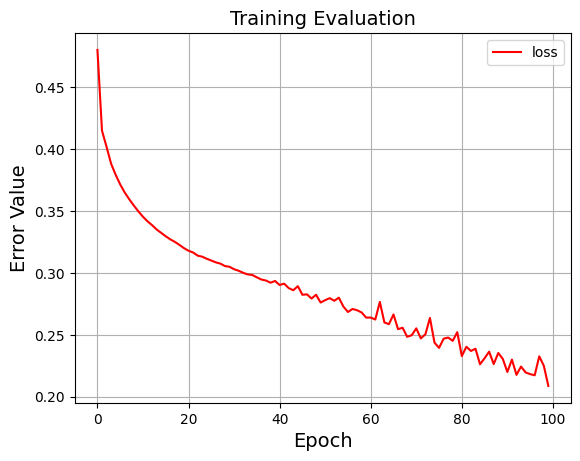

In [83]:
plt.plot(losses, label='loss', color='red')
plt.title('Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [84]:
predictions = model1.forward(X_train_orig)

metric = BinaryAccuracy()

# 3. Refactor the code so that the predictions will be like 
#   the expected output
# preds = predictions.detach().cpu().numpy()
preds = torch.where(predictions <= 0.50, 0, predictions)
preds = torch.where(preds > 0.50, 1, preds)
preds = torch.Tensor(preds)

accuracy = metric(preds, y_train_orig)
print("Train accuracy: ", float(accuracy))

Train accuracy:  0.8914881944656372


In [85]:
predictions = model1.forward(X_test_set)

metric = BinaryAccuracy()

# 3. Refactor the code so that the predictions will be like 
#   the expected output
# preds = predictions.detach().cpu().numpy()
preds = torch.where(predictions <= 0.50, 0, predictions)
preds = torch.where(preds > 0.50, 1, preds)
preds = torch.Tensor(preds)

accuracy = metric(preds, y_test_set)
print("Test accuracy: ", float(accuracy))

Test accuracy:  0.8672482967376709


In [87]:
state = { 'state_dict': model1.state_dict() }

torch.save(state, "models/wdbc_model_orig.pth")

### Train with Fabricated Data

In [88]:
model2 = NeuralNetwork(10, 2)

preds = model2.forward(X_train_fabricated)

preds

tensor([[0.5008, 0.4995],
        [0.5008, 0.4993],
        [0.5009, 0.4995],
        ...,
        [0.5010, 0.4994],
        [0.5010, 0.4995],
        [0.5010, 0.4994]], grad_fn=<SigmoidBackward0>)

In [91]:
learning_rate = 0.001
loss_fn = nn.BCELoss()
optimizer = optim.RMSprop(model2.parameters(), lr=learning_rate)
batch_size = 128

In [92]:
# Define the training process
# Each call of the train function == 1 Epoch
def train_neural_network(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        predictions = model.forward(data)
        
        loss = loss_fn(predictions, targets)
                
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

# Dataloader is in charge of:
# - partitioning data into batches
# - optionally shuffling the data
# - run the optimizer against a partition defined by this loader
custom_dataset = MyCustomDataset(x=X_train_orig, y=y_train_orig)

train_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

epochs = 100
losses = []
accuracies = []
lowest_loss = 0

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_neural_network(
        train_loader,
        model2,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
#     accuracies.append(ave_acc)
    
    print("Ave Loss: {}".format(ave_loss))
#     print("Ave Accuracy: {}".format(ave_acc))
    

#     lowest_loss = ave_loss

    state = { 'state_dict': model2.state_dict() }

    torch.save(state, "models/magic04_model_fab.pth")

Epoch: 0


100%|█████████████| 117/117 [00:00<00:00, 119.61it/s, loss=0.451]


Ave Loss: 0.41332582530812323
Epoch: 1


100%|█████████████| 117/117 [00:00<00:00, 127.55it/s, loss=0.434]


Ave Loss: 0.3684199052488702
Epoch: 2


100%|█████████████| 117/117 [00:00<00:00, 123.90it/s, loss=0.432]


Ave Loss: 0.360554906547579
Epoch: 3


100%|█████████████| 117/117 [00:00<00:00, 126.42it/s, loss=0.424]


Ave Loss: 0.35646262994179356
Epoch: 4


100%|██████████████| 117/117 [00:01<00:00, 109.10it/s, loss=0.42]


Ave Loss: 0.353109681708181
Epoch: 5


100%|█████████████| 117/117 [00:00<00:00, 123.33it/s, loss=0.422]


Ave Loss: 0.3499947562176957
Epoch: 6


100%|██████████████| 117/117 [00:00<00:00, 126.63it/s, loss=0.42]


Ave Loss: 0.34722370813545
Epoch: 7


100%|██████████████| 117/117 [00:00<00:00, 125.94it/s, loss=0.42]


Ave Loss: 0.3450944711509933
Epoch: 8


100%|█████████████| 117/117 [00:01<00:00, 116.24it/s, loss=0.417]


Ave Loss: 0.3423282562667488
Epoch: 9


100%|█████████████| 117/117 [00:01<00:00, 111.26it/s, loss=0.421]


Ave Loss: 0.33976148234473336
Epoch: 10


100%|█████████████| 117/117 [00:00<00:00, 124.34it/s, loss=0.419]


Ave Loss: 0.3378786528721834
Epoch: 11


100%|█████████████| 117/117 [00:00<00:00, 129.60it/s, loss=0.426]


Ave Loss: 0.33591297103299034
Epoch: 12


100%|█████████████| 117/117 [00:00<00:00, 136.29it/s, loss=0.418]


Ave Loss: 0.33417785740815675
Epoch: 13


100%|█████████████| 117/117 [00:00<00:00, 131.48it/s, loss=0.418]


Ave Loss: 0.33221134938235974
Epoch: 14


100%|█████████████| 117/117 [00:00<00:00, 126.82it/s, loss=0.422]


Ave Loss: 0.33064347836706376
Epoch: 15


100%|█████████████| 117/117 [00:00<00:00, 135.84it/s, loss=0.422]


Ave Loss: 0.3291525309666609
Epoch: 16


100%|██████████████| 117/117 [00:00<00:00, 131.92it/s, loss=0.42]


Ave Loss: 0.3281865682866838
Epoch: 17


100%|█████████████| 117/117 [00:00<00:00, 126.81it/s, loss=0.421]


Ave Loss: 0.3259502659496079
Epoch: 18


100%|█████████████| 117/117 [00:00<00:00, 125.72it/s, loss=0.423]


Ave Loss: 0.32501109109984505
Epoch: 19


100%|█████████████| 117/117 [00:01<00:00, 102.46it/s, loss=0.426]


Ave Loss: 0.3230022945974627
Epoch: 20


100%|█████████████| 117/117 [00:00<00:00, 130.74it/s, loss=0.423]


Ave Loss: 0.32224589853714675
Epoch: 21


100%|██████████████| 117/117 [00:01<00:00, 112.87it/s, loss=0.42]


Ave Loss: 0.320005832064865
Epoch: 22


100%|█████████████| 117/117 [00:01<00:00, 113.15it/s, loss=0.414]


Ave Loss: 0.3193397859477589
Epoch: 23


100%|██████████████| 117/117 [00:01<00:00, 110.73it/s, loss=0.42]


Ave Loss: 0.31757653574658257
Epoch: 24


100%|█████████████| 117/117 [00:00<00:00, 129.49it/s, loss=0.423]


Ave Loss: 0.31636401348643833
Epoch: 25


100%|██████████████| 117/117 [00:00<00:00, 129.46it/s, loss=0.43]


Ave Loss: 0.3141490385318414
Epoch: 26


100%|█████████████| 117/117 [00:00<00:00, 134.20it/s, loss=0.424]


Ave Loss: 0.31289050237745303
Epoch: 27


100%|██████████████| 117/117 [00:00<00:00, 130.57it/s, loss=0.42]


Ave Loss: 0.31187729028045624
Epoch: 28


100%|█████████████| 117/117 [00:00<00:00, 127.72it/s, loss=0.422]


Ave Loss: 0.3090917498637468
Epoch: 29


100%|█████████████| 117/117 [00:00<00:00, 132.30it/s, loss=0.434]


Ave Loss: 0.3103968837322333
Epoch: 30


100%|█████████████| 117/117 [00:00<00:00, 122.13it/s, loss=0.421]


Ave Loss: 0.30787551504933935
Epoch: 31


100%|█████████████| 117/117 [00:00<00:00, 134.56it/s, loss=0.421]


Ave Loss: 0.30539878769817513
Epoch: 32


100%|█████████████| 117/117 [00:00<00:00, 130.06it/s, loss=0.435]


Ave Loss: 0.3072562790833987
Epoch: 33


100%|█████████████| 117/117 [00:00<00:00, 130.64it/s, loss=0.425]


Ave Loss: 0.30348202255037093
Epoch: 34


100%|█████████████| 117/117 [00:00<00:00, 126.03it/s, loss=0.427]


Ave Loss: 0.30299332024704695
Epoch: 35


100%|█████████████| 117/117 [00:00<00:00, 128.45it/s, loss=0.436]


Ave Loss: 0.3014160448159927
Epoch: 36


100%|█████████████| 117/117 [00:00<00:00, 130.04it/s, loss=0.408]


Ave Loss: 0.2993900512273495
Epoch: 37


100%|██████████████| 117/117 [00:00<00:00, 124.47it/s, loss=0.41]


Ave Loss: 0.29993977251215875
Epoch: 38


100%|█████████████| 117/117 [00:00<00:00, 130.14it/s, loss=0.407]


Ave Loss: 0.2995336883597904
Epoch: 39


100%|█████████████| 117/117 [00:00<00:00, 128.63it/s, loss=0.414]


Ave Loss: 0.29724889484226197
Epoch: 40


100%|█████████████| 117/117 [00:00<00:00, 130.77it/s, loss=0.418]


Ave Loss: 0.29960678938107616
Epoch: 41


100%|█████████████| 117/117 [00:00<00:00, 123.45it/s, loss=0.409]


Ave Loss: 0.2930447219783424
Epoch: 42


100%|█████████████| 117/117 [00:00<00:00, 128.70it/s, loss=0.401]


Ave Loss: 0.2945390244325002
Epoch: 43


100%|█████████████| 117/117 [00:00<00:00, 128.93it/s, loss=0.396]


Ave Loss: 0.29251750781495345
Epoch: 44


100%|█████████████| 117/117 [00:00<00:00, 125.51it/s, loss=0.419]


Ave Loss: 0.2931646264006949
Epoch: 45


100%|█████████████| 117/117 [00:00<00:00, 124.39it/s, loss=0.392]


Ave Loss: 0.2897094104789261
Epoch: 46


100%|█████████████| 117/117 [00:00<00:00, 118.87it/s, loss=0.404]


Ave Loss: 0.2898082757352764
Epoch: 47


100%|█████████████| 117/117 [00:00<00:00, 122.80it/s, loss=0.398]


Ave Loss: 0.2888471347908688
Epoch: 48


100%|█████████████| 117/117 [00:00<00:00, 120.21it/s, loss=0.391]


Ave Loss: 0.28646582377772045
Epoch: 49


100%|█████████████| 117/117 [00:00<00:00, 120.05it/s, loss=0.423]


Ave Loss: 0.289222151805193
Epoch: 50


100%|█████████████| 117/117 [00:00<00:00, 118.44it/s, loss=0.385]


Ave Loss: 0.2854278304128565
Epoch: 51


100%|█████████████| 117/117 [00:01<00:00, 113.98it/s, loss=0.395]


Ave Loss: 0.2846025648789528
Epoch: 52


100%|█████████████| 117/117 [00:00<00:00, 118.40it/s, loss=0.379]


Ave Loss: 0.28404641164164257
Epoch: 53


100%|█████████████| 117/117 [00:00<00:00, 120.28it/s, loss=0.393]


Ave Loss: 0.2837995013110658
Epoch: 54


100%|█████████████| 117/117 [00:00<00:00, 117.37it/s, loss=0.385]


Ave Loss: 0.28316038184695774
Epoch: 55


100%|█████████████| 117/117 [00:01<00:00, 115.73it/s, loss=0.383]


Ave Loss: 0.2857144361632502
Epoch: 56


100%|█████████████| 117/117 [00:01<00:00, 115.44it/s, loss=0.393]


Ave Loss: 0.2814017019720159
Epoch: 57


100%|██████████████| 117/117 [00:00<00:00, 118.21it/s, loss=0.38]


Ave Loss: 0.2820952979163227
Epoch: 58


100%|█████████████| 117/117 [00:01<00:00, 113.46it/s, loss=0.382]


Ave Loss: 0.2779886843557032
Epoch: 59


100%|█████████████| 117/117 [00:01<00:00, 115.01it/s, loss=0.369]


Ave Loss: 0.28277116313449335
Epoch: 60


100%|█████████████| 117/117 [00:01<00:00, 110.57it/s, loss=0.359]


Ave Loss: 0.2770432515276803
Epoch: 61


100%|██████████████| 117/117 [00:01<00:00, 94.81it/s, loss=0.363]


Ave Loss: 0.2750563621520996
Epoch: 62


100%|█████████████| 117/117 [00:01<00:00, 100.97it/s, loss=0.353]


Ave Loss: 0.2770527221708216
Epoch: 63


100%|██████████████| 117/117 [00:01<00:00, 98.54it/s, loss=0.373]


Ave Loss: 0.2810234926704668
Epoch: 64


100%|██████████████| 117/117 [00:01<00:00, 102.70it/s, loss=0.35]


Ave Loss: 0.2747856955497693
Epoch: 65


100%|█████████████| 117/117 [00:01<00:00, 110.34it/s, loss=0.346]


Ave Loss: 0.27064776140400487
Epoch: 66


100%|██████████████| 117/117 [00:01<00:00, 116.15it/s, loss=0.36]


Ave Loss: 0.2741954102475419
Epoch: 67


100%|█████████████| 117/117 [00:01<00:00, 114.81it/s, loss=0.346]


Ave Loss: 0.2668586887864985
Epoch: 68


100%|█████████████| 117/117 [00:01<00:00, 115.75it/s, loss=0.357]


Ave Loss: 0.27125439952071917
Epoch: 69


100%|█████████████| 117/117 [00:01<00:00, 113.23it/s, loss=0.364]


Ave Loss: 0.2733211393794443
Epoch: 70


100%|█████████████| 117/117 [00:01<00:00, 109.50it/s, loss=0.329]


Ave Loss: 0.2666283803872573
Epoch: 71


100%|█████████████| 117/117 [00:01<00:00, 113.38it/s, loss=0.369]


Ave Loss: 0.26767816757544494
Epoch: 72


100%|█████████████| 117/117 [00:01<00:00, 110.97it/s, loss=0.457]


Ave Loss: 0.2658635566377232
Epoch: 73


100%|█████████████| 117/117 [00:01<00:00, 114.48it/s, loss=0.331]


Ave Loss: 0.27707802115852
Epoch: 74


100%|█████████████| 117/117 [00:01<00:00, 112.98it/s, loss=0.396]


Ave Loss: 0.259310041482632
Epoch: 75


100%|█████████████| 117/117 [00:01<00:00, 108.88it/s, loss=0.339]


Ave Loss: 0.2620645439268177
Epoch: 76


100%|█████████████| 117/117 [00:01<00:00, 114.27it/s, loss=0.357]


Ave Loss: 0.25823096039458215
Epoch: 77


100%|█████████████| 117/117 [00:01<00:00, 115.79it/s, loss=0.337]


Ave Loss: 0.2618762533634137
Epoch: 78


100%|█████████████| 117/117 [00:01<00:00, 110.55it/s, loss=0.314]


Ave Loss: 0.2575692607042117
Epoch: 79


100%|█████████████| 117/117 [00:01<00:00, 110.55it/s, loss=0.325]


Ave Loss: 0.26170067145274234
Epoch: 80


100%|█████████████| 117/117 [00:01<00:00, 112.11it/s, loss=0.364]


Ave Loss: 0.260303657151695
Epoch: 81


100%|█████████████| 117/117 [00:01<00:00, 110.25it/s, loss=0.358]


Ave Loss: 0.25704554156360465
Epoch: 82


100%|██████████████| 117/117 [00:01<00:00, 110.87it/s, loss=0.36]


Ave Loss: 0.2632653261097068
Epoch: 83


100%|██████████████| 117/117 [00:01<00:00, 106.19it/s, loss=0.32]


Ave Loss: 0.2521937876685053
Epoch: 84


100%|█████████████| 117/117 [00:01<00:00, 106.33it/s, loss=0.352]


Ave Loss: 0.2565242207457877
Epoch: 85


100%|█████████████| 117/117 [00:01<00:00, 100.27it/s, loss=0.298]


Ave Loss: 0.2518994573853974
Epoch: 86


100%|█████████████| 117/117 [00:01<00:00, 105.62it/s, loss=0.323]


Ave Loss: 0.24774293448680487
Epoch: 87


100%|█████████████| 117/117 [00:01<00:00, 106.79it/s, loss=0.297]


Ave Loss: 0.2484304828521533
Epoch: 88


100%|██████████████| 117/117 [00:01<00:00, 99.17it/s, loss=0.343]


Ave Loss: 0.2647456656663846
Epoch: 89


100%|█████████████| 117/117 [00:01<00:00, 102.34it/s, loss=0.363]


Ave Loss: 0.24412780006726584
Epoch: 90


100%|█████████████| 117/117 [00:01<00:00, 102.46it/s, loss=0.286]


Ave Loss: 0.23934284718627605
Epoch: 91


100%|█████████████| 117/117 [00:01<00:00, 108.98it/s, loss=0.306]


Ave Loss: 0.2423800134505981
Epoch: 92


100%|█████████████| 117/117 [00:01<00:00, 108.65it/s, loss=0.436]


Ave Loss: 0.24424810312752032
Epoch: 93


100%|█████████████| 117/117 [00:01<00:00, 104.24it/s, loss=0.304]


Ave Loss: 0.2433395849970671
Epoch: 94


100%|█████████████| 117/117 [00:01<00:00, 111.19it/s, loss=0.281]


Ave Loss: 0.2359898753909983
Epoch: 95


100%|█████████████| 117/117 [00:01<00:00, 106.82it/s, loss=0.294]


Ave Loss: 0.24162208034187302
Epoch: 96


100%|█████████████| 117/117 [00:01<00:00, 111.36it/s, loss=0.321]


Ave Loss: 0.24144827262458637
Epoch: 97


100%|██████████████| 117/117 [00:01<00:00, 107.47it/s, loss=0.28]


Ave Loss: 0.23728451947880608
Epoch: 98


100%|█████████████| 117/117 [00:01<00:00, 108.52it/s, loss=0.254]


Ave Loss: 0.23474350278703576
Epoch: 99


100%|██████████████| 117/117 [00:01<00:00, 109.51it/s, loss=0.26]

Ave Loss: 0.2278496887948778


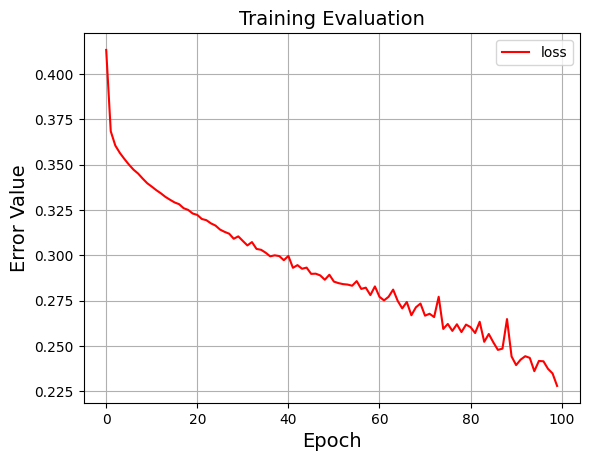

In [97]:
plt.plot(losses, label='loss', color='red')
plt.title('Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [98]:
predictions = model2.forward(X_train_fabricated)

metric = BinaryAccuracy()

# 3. Refactor the code so that the predictions will be like 
#   the expected output
# preds = predictions.detach().cpu().numpy()
preds = torch.where(predictions <= 0.50, 0, predictions)
preds = torch.where(preds > 0.50, 1, preds)
preds = torch.Tensor(preds)

accuracy = metric(preds, y_train_fabricated)
print("Train accuracy: ", float(accuracy))

Train accuracy:  0.9133725166320801


In [102]:
predictions = model2.forward(X_test_set)

metric = BinaryAccuracy()

# 3. Refactor the code so that the predictions will be like 
#   the expected output
# preds = predictions.detach().cpu().numpy()
preds = torch.where(predictions <= 0.50, 0, predictions)
preds = torch.where(preds > 0.50, 1, preds)
preds = torch.Tensor(preds)

accuracy = metric(preds, y_test_set)
print("Test accuracy: ", float(accuracy))

Test accuracy:  0.8651006817817688


In [103]:
state = { 'state_dict': model2.state_dict() }

torch.save(state, "models/magic04_model_fab.pth")